Inportamos las Librerias

In [21]:
import numpy as np
import pandas as pd
import json
import joblib
from sklearn.preprocessing import StandardScaler
# modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import SGDRegressor
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb


In [22]:
df = pd.read_csv("listings.csv", index_col= "id")
# corregimos algunas colunas y sacamos otras.
df.drop(columns=['license','last_review','number_of_reviews_ltm','neighbourhood','name','host_id','host_name','latitude','longitude','last_review','calculated_host_listings_count'],inplace=True)
df['price'].fillna((df['price'].mean()),inplace=True)
df['reviews_per_month'].fillna(0,inplace=True)
df

,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365
id,,,,,,,
34421962,Kauai,Entire home/apt,417.000000,1,0,0.00,243
40707945,Honolulu,Private room,290.000000,1,0,0.00,365
43656551,Honolulu,Entire home/apt,199.000000,1,52,1.51,145
39096262,Honolulu,Private room,409.804454,365,0,0.00,0
735005738415289686,Kauai,Private room,409.804454,7,0,0.00,353
...,...,...,...,...,...,...,...
755988499595645037,Hawaii,Entire home/apt,409.804454,2,3,0.21,89
756678668207738929,Hawaii,Entire home/apt,409.804454,2,0,0.00,0
969798240699256199,Kauai,Private room,409.804454,5,0,0.00,0


In [23]:
df.columns

Index(['neighbourhood_group', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month', 'availability_365'],
      dtype='object')

In [24]:
df.isnull().sum() * 100 / len(df)

neighbourhood_group    0.0
room_type              0.0
price                  0.0
minimum_nights         0.0
number_of_reviews      0.0
reviews_per_month      0.0
availability_365       0.0
dtype: float64

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34049 entries, 34421962 to 891631866049506737
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   neighbourhood_group  34049 non-null  object 
 1   room_type            34049 non-null  object 
 2   price                34049 non-null  float64
 3   minimum_nights       34049 non-null  int64  
 4   number_of_reviews    34049 non-null  int64  
 5   reviews_per_month    34049 non-null  float64
 6   availability_365     34049 non-null  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 2.1+ MB


In [26]:
df.head()

,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365
id,,,,,,,
34421962,Kauai,Entire home/apt,417.000000,1,0,0.00,243
40707945,Honolulu,Private room,290.000000,1,0,0.00,365
43656551,Honolulu,Entire home/apt,199.000000,1,52,1.51,145
39096262,Honolulu,Private room,409.804454,365,0,0.00,0
735005738415289686,Kauai,Private room,409.804454,7,0,0.00,353


In [27]:
# Encontramos los outliers
def outliers (df):
    for columnas in df:
        if df[columnas].dtype in ['int64', 'float64']:  

            Q1 = df[columnas].quantile(0.25)
            Q3 = df[columnas].quantile(0.75)
            IQR = Q3 - Q1
            outlierIzq = Q1-(1.5*IQR)
            outlierDer = Q3+(1.5*IQR)
            outliers = df[columnas][(df[columnas] < outlierIzq) | (df[columnas] > outlierDer)]
            print("Variable " + columnas + " has (" + str(len(outliers)) + ") outliers")

    
outliers(df)

Variable price has (3011) outliers
Variable minimum_nights has (3764) outliers
Variable number_of_reviews has (3699) outliers
Variable reviews_per_month has (2061) outliers
Variable availability_365 has (0) outliers


In [28]:
# creamos una funcion para reparar los outliers
def reparar_atipicos(df, col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    
    atipico_inf = Q1 - (1.5 * IQR)
    atipico_sup = Q3 + (1.5 * IQR)
    
    for indice in range(len(df[col.name])): 
        if indice in df.index:  
            elemento = df.loc[indice, col.name] 
            if elemento > atipico_sup: 
                df.loc[indice, col.name] = atipico_sup
            elif elemento < atipico_inf: 
                df.loc[indice, col.name] = atipico_inf
            
    return df  

#reparamos los outliers
reparar_atipicos(df, df['price'])

,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365
id,,,,,,,
34421962,Kauai,Entire home/apt,417.000000,1,0,0.00,243
40707945,Honolulu,Private room,290.000000,1,0,0.00,365
43656551,Honolulu,Entire home/apt,199.000000,1,52,1.51,145
39096262,Honolulu,Private room,409.804454,365,0,0.00,0
735005738415289686,Kauai,Private room,409.804454,7,0,0.00,353
...,...,...,...,...,...,...,...
755988499595645037,Hawaii,Entire home/apt,409.804454,2,3,0.21,89
756678668207738929,Hawaii,Entire home/apt,409.804454,2,0,0.00,0
969798240699256199,Kauai,Private room,409.804454,5,0,0.00,0


In [29]:
# Test de la distribuicion dentro de las columnas.
from scipy.stats import skew
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_columns:
    skewness_value = skew(df[col])
    if -0.5 <= skewness_value <= 0.5:
        skewness_range = "La distribución es aproximadamente simétrica."
    elif -1 <= skewness_value < -0.5 or 0.5 < skewness_value <= 1:
        skewness_range = "La distribución es moderadamente asimétrica."
    else:
        skewness_range = "La distribución es altamente asimétrica."
    print(f'Skewness ({col}): {skewness_value:.4f} - {skewness_range}')

Skewness (price): 17.6224 - La distribución es altamente asimétrica.
Skewness (minimum_nights): 8.1176 - La distribución es altamente asimétrica.
Skewness (number_of_reviews): 4.4166 - La distribución es altamente asimétrica.
Skewness (reviews_per_month): 4.3660 - La distribución es altamente asimétrica.
Skewness (availability_365): -0.3362 - La distribución es aproximadamente simétrica.


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34049 entries, 34421962 to 891631866049506737
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   neighbourhood_group  34049 non-null  object 
 1   room_type            34049 non-null  object 
 2   price                34049 non-null  float64
 3   minimum_nights       34049 non-null  int64  
 4   number_of_reviews    34049 non-null  int64  
 5   reviews_per_month    34049 non-null  float64
 6   availability_365     34049 non-null  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 3.1+ MB


In [31]:
df_filtrado = df.copy()

In [32]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_filtrado['neighbourhood_group'] = label_encoder.fit_transform(df_filtrado['neighbourhood_group'])
df_filtrado['room_type'] = label_encoder.fit_transform(df_filtrado['room_type'])

In [33]:

df_filtrado

,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365
id,,,,,,,
34421962,2,0,417.000000,1,0,0.00,243
40707945,1,2,290.000000,1,0,0.00,365
43656551,1,0,199.000000,1,52,1.51,145
39096262,1,2,409.804454,365,0,0.00,0
735005738415289686,2,2,409.804454,7,0,0.00,353
...,...,...,...,...,...,...,...
755988499595645037,0,0,409.804454,2,3,0.21,89
756678668207738929,0,0,409.804454,2,0,0.00,0
969798240699256199,2,2,409.804454,5,0,0.00,0


# resolver seaborn

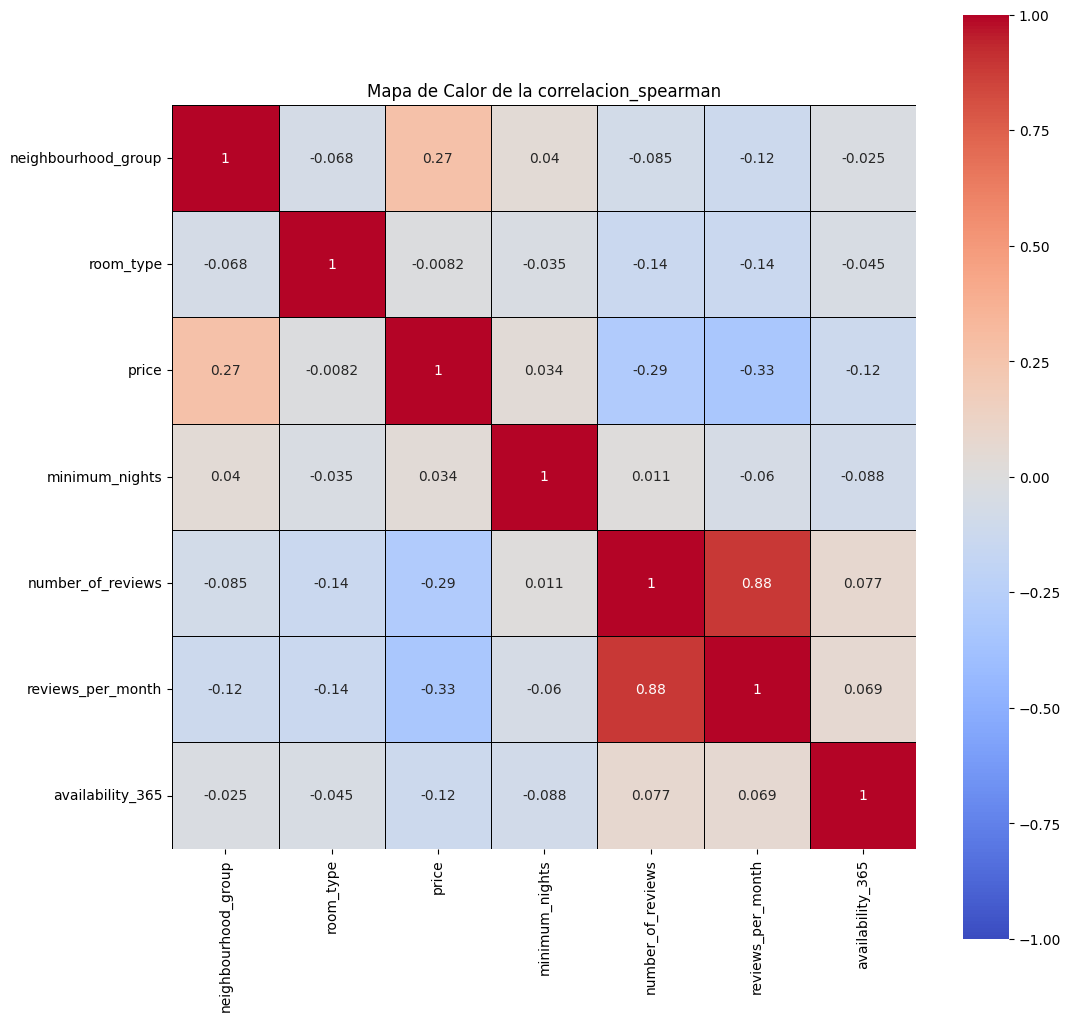

In [34]:
# Método de Spearman (Mide una dependencia no paramétrica y monotónica entre variables) 
import matplotlib.pyplot as plt
import seaborn as sns
correlacion_spearman = df_filtrado.corr(method='spearman')
plt.figure(figsize=(12, 12))
sns.heatmap(correlacion_spearman, vmax=1, vmin=-1, annot=True, square=True, linewidths=0.5, cmap='coolwarm', linecolor='black')
plt.title('Mapa de Calor de la correlacion_spearman')
plt.show()

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [36]:
def train_model_forest(df):
    # Filtrando as colunas de entrada e a coluna de saída (target)
    X = df.drop(columns=['price'])
    y = df['price']
    
    # Dividindo o dataset em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=342)
    
    # Treinando o modelo
    model = RandomForestRegressor(n_estimators=100, random_state=342)
    model.fit(X_train, y_train)
    
    # Avaliando o modelo
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    
    return model

In [37]:
# Treinar o modelo
modelo_treinado_train = train_model_forest(df_filtrado)

Mean Squared Error: 371073.42723159


In [38]:
def train_model_linear(df):
    # Filtrando as colunas de entrada e a coluna de saída (target)
    X = df.drop(columns=['price'])
    y = df['price']
    
    # Dividindo o dataset em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Treinando o modelo
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Avaliando o modelo
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    
    return model


In [39]:
# Treinar o modelo
modelo_treinado_linear = train_model_linear(df_filtrado)

Mean Squared Error: 562913.8741186416


In [40]:
import joblib
joblib.dump(modelo_treinado_linear, 'modelo_linear.pkl')
joblib.dump(modelo_treinado_train, 'modelo_train.pkl')

['modelo_train.pkl']